In [3]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 32768 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Qwen/Qwen3-0.6B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    full_finetuning = True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


INFO 06-09 10:08:12 [importing.py:53] Triton module has been replaced with a placeholder.


INFO 06-09 10:08:12 [__init__.py:239] Automatically detected platform cuda.


2025-06-09 10:08:14,271	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


==((====))==  Unsloth 2025.5.3: Fast Qwen3 patching. Transformers: 4.51.3. vLLM: 0.8.5.
   \\   /|    Tesla V100-SXM2-32GB. Num GPUs = 1. Max memory: 31.749 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: Float16 full finetuning uses more memory since we upcast weights to float32.


In [ ]:
from datasets import load_dataset

# Define the paths to your dataset files
data_files = {
    'train': 'severity_data_train.csv',
    'val': 'severity_data_val.csv',
    'test': 'severity_data_test.csv'
}

# Load the dataset
dataset = load_dataset('csv', data_files=data_files)

In [5]:
import random
from datasets import concatenate_datasets, DatasetDict

random.seed(42)

SYSTEM_PROMPT = [
    """You are the smartest AI solidity smart contract security auditor in the world.""",
    """You are the greatest AI assistant smart contract security auditor in the world.""",
    """You are the best solidity smart contract security auditor in the world""",
    """You are the greatest AI assistant solidity security researcher in the world""",
    """You are the best AI solidity smart contract security auditor in the world."""
]

PROMPTS = [
    """You need to analyze the given vulnerability explanation and classify the severity of it as "low", "medium" or "high" based on the impact of that vulnerability.
    
    This is the vulnerability explanation we need to analyze:
    {explanation}
    
Answer: """,
    
    """Analyze the given vulnerability explanation and determine whether the severity is "low", "medium" or "high" based on the impact if the vulnerability exploited.
    
    Vulnerability explanation to analyze:
    {explanation}
    
Answer: """,

    """Examine the given vulnerability explanation below and assess the severity is it "low", "medium" or "high".
    
    Vulnerability explanation to examine:
    {explanation}
    
Answer: """,

    """Review the vulnerability explanation and classify the severity as "low", "medium" or "high" by checking if the exploitation is occured then how is it will impact the system.
    
    Vulnerability explanation:
    {explanation}
    
Answer: """,

    """Audit the given vulnerability explanation to determine if the severity should be categorized as "low", "medium" or "high".
    
    Vulnerability explanation:
    {explanation}
    
Answer: """,
]

def make_conversational(examples, system_prompt, prompt):
    explanation = examples['vuln_explanation']
    severity = examples['severity']
    selected_system_prompt = system_prompt
    selected_user_prompt = prompt
    conversation = [{"role": "system", "content": selected_system_prompt}, 
                    {"role": "user", "content": selected_user_prompt.format(explanation=explanation)},
                    {"role": "assistant", "content": severity}]
    
    return { "conversations" : conversation}

# List of splits you want to process
splits = ['train', 'val', 'test']

# Dictionary to store concatenated datasets for each split
concatenated_datasets = {split: [] for split in splits}

# Process each dataset
for i in range(5):
    system_prompt = SYSTEM_PROMPT[i]
    prompt = PROMPTS[i]
    
    # Create a new dataset using map
    new_dataset = dataset.map(lambda ex: make_conversational(ex, system_prompt, prompt))
    
    # Append the correct split of the new dataset to the corresponding list
    for split in splits:
        concatenated_datasets[split].append(new_dataset[split])

# Now concatenate all datasets for each split
dataset = DatasetDict({
    split: concatenate_datasets(concatenated_datasets[split]).shuffle(seed=42) for split in splits
})

dataset = dataset.remove_columns(["file_name", "vuln_title", "vuln_explanation", "vuln_recommendation", "vuln_code"])

In [ ]:
from unsloth.chat_templates import get_chat_template

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False, enable_thinking=False) for convo in convos]
    return { "text" : texts, }

dataset = dataset.map(formatting_prompts_func, batched = True,)

In [7]:
dataset['train'][5]["conversations"]

[{'content': 'You are the greatest AI assistant solidity security researcher in the world',
  'role': 'system'},
 {'content': 'Review the vulnerability explanation and classify the severity as "low", "medium" or "high" by checking if the exploitation is occured then how is it will impact the system.\n    \n    Vulnerability explanation:\n    The `mint()` method is malfunction because of the extra `nonReentrant` modifier, as `mintTo` already has a `nonReentrant` modifier.\n    \nAnswer: ',
  'role': 'user'},
 {'content': 'medium', 'role': 'assistant'}]

In [8]:
dataset['train'][5]["text"]

'<|im_start|>system\nYou are the greatest AI assistant solidity security researcher in the world<|im_end|>\n<|im_start|>user\nReview the vulnerability explanation and classify the severity as "low", "medium" or "high" by checking if the exploitation is occured then how is it will impact the system.\n    \n    Vulnerability explanation:\n    The `mint()` method is malfunction because of the extra `nonReentrant` modifier, as `mintTo` already has a `nonReentrant` modifier.\n    \nAnswer: <|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\nmedium<|im_end|>\n'

In [9]:
tokenized = dataset['train'].map(
    lambda x: {"tokens" : tokenizer.apply_chat_template(x["conversations"], add_generation_prompt = True, tokenize = True)},
    batched = True,
)
# print(tokenizer.decode(tokenized[0]["tokens"]))
tokenized = tokenized.map(lambda x: {"L" : len(x["tokens"])})

import numpy as np
maximum_length = int(np.quantile(tokenized["L"], 0.9))
print("Train Max Length = ", maximum_length)

# Filter only samples smaller than 90% max length
dataset['train'] = dataset['train'].select(np.where(np.array(tokenized["L"]) <= maximum_length)[0])
del tokenized

Train Max Length =  536


In [10]:
tokenized = dataset['val'].map(
    lambda x: {"tokens" : tokenizer.apply_chat_template(x["conversations"], add_generation_prompt = True, tokenize = True)},
    batched = True,
)
tokenized = tokenized.map(lambda x: {"L" : len(x["tokens"])})

import numpy as np
maximum_length = int(np.quantile(tokenized["L"], 0.9))
print("Val Max Length = ", maximum_length)

# Filter only samples smaller than 90% max length
dataset['val'] = dataset['val'].select(np.where(np.array(tokenized["L"]) <= maximum_length)[0])
del tokenized

Val Max Length =  485


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

train_dataset = dataset['train']
val_dataset = dataset['val']

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 4,
    packing = False, 
    args = TrainingArguments(
        eval_strategy="steps",
        eval_steps=100,
        save_steps=100,
        per_device_train_batch_size = 32,
        per_device_eval_batch_size = 32,
        gradient_accumulation_steps = 2, 
        warmup_ratio = 0.1,
        num_train_epochs = 5, 
        learning_rate = 2e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit", 
        weight_decay= 1.0,
        lr_scheduler_type = "cosine",
        seed = 3407,
        load_best_model_at_end=True,
        output_dir = "outputs_severity_v2",
        report_to = "none", 
    ),
)

Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [12]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|im_start|>user\n",
    response_part = "<|im_start|>assistant\n",
)

In [13]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<|im_start|>system\nYou are the greatest AI assistant solidity security researcher in the world<|im_end|>\n<|im_start|>user\nReview the vulnerability explanation and classify the severity as "low", "medium" or "high" by checking if the exploitation is occured then how is it will impact the system.\n    \n    Vulnerability explanation:\n    The `mint()` method is malfunction because of the extra `nonReentrant` modifier, as `mintTo` already has a `nonReentrant` modifier.\n    \nAnswer: <|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\nmedium<|im_end|>\n'

In [14]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

'                                                                                                        <think>\n\n</think>\n\nmedium<|im_end|>\n'

In [15]:
tokenizer.decode(trainer.eval_dataset[5]["input_ids"])

'<|im_start|>system\nYou are the smartest AI solidity smart contract security auditor in the world.<|im_end|>\n<|im_start|>user\nYou need to analyze the given vulnerability explanation and classify the severity of it as "low", "medium" or "high" based on the impact of that vulnerability.\n    \n    This is the vulnerability explanation we need to analyze:\n    The `safeTransferFrom` does not comply with the ERC1155 standard when the token is sent to the old owner.\n\nAccording to the EIP-1155 standard for the `safeTransferFrom`:\n\n> MUST revert if balance of holder for token `_id` is lower than the `_value` sent.\n\nLet\'s say `alice` does not hold any token of `tokenId`, and `bob` holds one token of `tokenId`. Then alice tries to send one token of `tokenId` to bob with `safeTranferFrom(alice, bob, tokenId, 1, "")`.  In this case, even though alice\'s balance (= 0) is lower than the amount (= 1) sent, the `safeTransferFrom` will not revert. Thus, violating the EIP-1155 standard.\nIt c

In [16]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.eval_dataset[5]["labels"]])

'                                                                                                                                                                                                                                                                                                     <think>\n\n</think>\n\nmedium<|im_end|>\n'

In [17]:
from unsloth import unsloth_train
# trainer_stats = trainer.train() << Buggy gradient accumulation
trainer_stats = unsloth_train(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,979 | Num Epochs = 5 | Total steps = 235
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 2 x 1) = 64
 "-____-"     Trainable parameters = 596,049,920/596,049,920 (100.00% trained)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
100,0.001400,0.279493
200,0.000000,0.466469


Unsloth: Not an error, but Qwen3Model does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [ ]:
model.save_pretrained("ours_severity")
tokenizer.save_pretrained("ours_severity")

In [ ]:
from datasets import load_dataset

# Define the paths to your dataset files
data_files = {
    'train': 'severity_data_train.csv',
    'val': 'severity_data_val.csv',
    'test': 'severity_data_test.csv'
}

# Load the dataset
dataset = load_dataset('csv', data_files=data_files)

import random
from datasets import concatenate_datasets, DatasetDict

random.seed(42)

SYSTEM_PROMPT = [
    """You are the smartest AI solidity smart contract security auditor in the world.""",
    """You are the greatest AI assistant smart contract security auditor in the world.""",
    """You are the best solidity smart contract security auditor in the world""",
    """You are the greatest AI assistant solidity security researcher in the world""",
    """You are the best AI solidity smart contract security auditor in the world."""
]

PROMPTS = [
    """You need to analyze the given vulnerability explanation and classify the severity of it as "low", "medium" or "high" based on the impact of that vulnerability.
    
    This is the vulnerability explanation we need to analyze:
    {explanation}
    
Answer: """,
    
    """Analyze the given vulnerability explanation and determine whether the severity is "low", "medium" or "high" based on the impact if the vulnerability exploited.
    
    Vulnerability explanation to analyze:
    {explanation}
    
Answer: """,

    """Examine the given vulnerability explanation below and assess the severity is it "low", "medium" or "high".
    
    Vulnerability explanation to examine:
    {explanation}
    
Answer: """,

    """Review the vulnerability explanation and classify the severity as "low", "medium" or "high" by checking if the exploitation is occured then how is it will impact the system.
    
    Vulnerability explanation:
    {explanation}
    
Answer: """,

    """Audit the given vulnerability explanation to determine if the severity should be categorized as "low", "medium" or "high".
    
    Vulnerability explanation:
    {explanation}
    
Answer: """,
]

def make_conversational_vote(examples, system_prompt, prompt):
    explanation = examples['vuln_explanation']
    severity = examples['severity']
    selected_system_prompt = system_prompt
    selected_user_prompt = prompt
    conversation = [{"role": "system", "content": selected_system_prompt}, 
                    {"role": "user", "content": selected_user_prompt.format(explanation=explanation)}]
    
    return { "conversations" : conversation, 'label': severity}

# Generate 5 datasets using different prompts
datasets = []
for i in range(len(PROMPTS)):
    new_dataset = dataset.map(lambda ex: make_conversational_vote(ex, SYSTEM_PROMPT[i], PROMPTS[i]))
    new_dataset = new_dataset.remove_columns(["file_name", "vuln_title", "vuln_explanation", "vuln_recommendation", "vuln_code"])
    datasets.append(new_dataset)
    
test_dataset = datasets[0]['test']

In [20]:
from tqdm import tqdm
import re

# Inference with majority voting
pattern = r"<\|im_start\|>assistant\n<think>\n\n</think>\n\n(.*?)<\|im_end\|>"
y_preds = [[] for _ in range(5)]

for i, dataset in enumerate(datasets):
    for messages in tqdm(dataset['test']['conversations']):
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            enable_thinking=False,
            add_generation_prompt=True,
            return_tensors="pt",
        ).to("cuda")

        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=8,
            use_cache=True,
            temperature=0.1,
            min_p=0.1
        )
        decoded_output = tokenizer.batch_decode(outputs)[0]
        match = re.search(pattern, decoded_output, re.DOTALL)
        extracted_label = match.group(1).strip() if match else "Unknown"
        y_preds[i].append(extracted_label)
        
# Majority voting
final_predictions = []
for preds in zip(*y_preds):
    vote_count = {"low": 0, "medium": 0, "high": 0}
    for pred in preds:
        if pred in vote_count:
            vote_count[pred] += 1
    final_prediction = max(vote_count, key=vote_count.get)
    final_predictions.append(final_prediction)

print("Final Predictions:", final_predictions)


  0%|                                                                                             | 0/143 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



  1%|▌                                                                                    | 1/143 [00:04<10:07,  4.28s/it]


  1%|█▏                                                                                   | 2/143 [00:04<04:19,  1.84s/it]


  2%|█▊                                                                                   | 3/143 [00:04<02:28,  1.06s/it]


  3%|██▍                                                                                  | 4/143 [00:04<01:36,  1.44it/s]


  3%|██▉                                                                                  | 5/143 [00:04<01:07,  2.03it/s]


  4%|███▌                                                                                 | 6/143 [00:04<00:50,  2.71it/s]


  5%|████▏                                                                                | 7/143 [00:05<00:39,  3.41it/s]


  6%|████▊                                                                                | 8/143 [00:05<00:32,  4.13it/s]


  6%|█████▎                                                                               | 9/143 [00:05<00:27,  4.81it/s]


  7%|█████▊                                                                              | 10/143 [00:05<00:24,  5.43it/s]


  8%|██████▍                                                                             | 11/143 [00:05<00:22,  5.95it/s]


  8%|███████                                                                             | 12/143 [00:05<00:20,  6.36it/s]


  9%|███████▋                                                                            | 13/143 [00:05<00:19,  6.69it/s]


 10%|████████▏                                                                           | 14/143 [00:06<00:18,  6.95it/s]


 10%|████████▊                                                                           | 15/143 [00:06<00:18,  7.11it/s]


 11%|█████████▍                                                                          | 16/143 [00:06<00:17,  7.21it/s]


 12%|█████████▉                                                                          | 17/143 [00:06<00:17,  7.33it/s]


 13%|██████████▌                                                                         | 18/143 [00:06<00:16,  7.38it/s]


 13%|███████████▏                                                                        | 19/143 [00:06<00:16,  7.45it/s]


 14%|███████████▋                                                                        | 20/143 [00:06<00:16,  7.49it/s]


 15%|████████████▎                                                                       | 21/143 [00:06<00:16,  7.50it/s]


 15%|████████████▉                                                                       | 22/143 [00:07<00:16,  7.56it/s]


 16%|█████████████▌                                                                      | 23/143 [00:07<00:16,  7.45it/s]


 17%|██████████████                                                                      | 24/143 [00:07<00:15,  7.44it/s]


 17%|██████████████▋                                                                     | 25/143 [00:07<00:15,  7.49it/s]


 18%|███████████████▎                                                                    | 26/143 [00:07<00:15,  7.50it/s]


 19%|███████████████▊                                                                    | 27/143 [00:07<00:15,  7.46it/s]


 20%|████████████████▍                                                                   | 28/143 [00:07<00:15,  7.50it/s]


 20%|█████████████████                                                                   | 29/143 [00:07<00:15,  7.51it/s]


 21%|█████████████████▌                                                                  | 30/143 [00:08<00:15,  7.52it/s]


 22%|██████████████████▏                                                                 | 31/143 [00:08<00:15,  7.23it/s]


 22%|██████████████████▊                                                                 | 32/143 [00:08<00:15,  7.25it/s]


 23%|███████████████████▍                                                                | 33/143 [00:08<00:14,  7.34it/s]


 24%|███████████████████▉                                                                | 34/143 [00:08<00:14,  7.42it/s]


 24%|████████████████████▌                                                               | 35/143 [00:08<00:14,  7.48it/s]


 25%|█████████████████████▏                                                              | 36/143 [00:08<00:14,  7.51it/s]


 26%|█████████████████████▋                                                              | 37/143 [00:09<00:14,  7.56it/s]


 27%|██████████████████████▎                                                             | 38/143 [00:09<00:13,  7.56it/s]


 27%|██████████████████████▉                                                             | 39/143 [00:09<00:13,  7.60it/s]


 28%|███████████████████████▍                                                            | 40/143 [00:09<00:13,  7.58it/s]


 29%|████████████████████████                                                            | 41/143 [00:09<00:13,  7.61it/s]


 29%|████████████████████████▋                                                           | 42/143 [00:09<00:13,  7.64it/s]


 30%|█████████████████████████▎                                                          | 43/143 [00:09<00:13,  7.63it/s]


 31%|█████████████████████████▊                                                          | 44/143 [00:09<00:12,  7.63it/s]


 31%|██████████████████████████▍                                                         | 45/143 [00:10<00:12,  7.60it/s]


 32%|███████████████████████████                                                         | 46/143 [00:10<00:12,  7.60it/s]


 33%|███████████████████████████▌                                                        | 47/143 [00:10<00:12,  7.62it/s]


 34%|████████████████████████████▏                                                       | 48/143 [00:10<00:12,  7.63it/s]


 34%|████████████████████████████▊                                                       | 49/143 [00:10<00:12,  7.65it/s]


 35%|█████████████████████████████▎                                                      | 50/143 [00:10<00:12,  7.65it/s]


 36%|█████████████████████████████▉                                                      | 51/143 [00:10<00:12,  7.63it/s]


 36%|██████████████████████████████▌                                                     | 52/143 [00:11<00:11,  7.64it/s]


 37%|███████████████████████████████▏                                                    | 53/143 [00:11<00:11,  7.60it/s]


 38%|███████████████████████████████▋                                                    | 54/143 [00:11<00:11,  7.61it/s]


 38%|████████████████████████████████▎                                                   | 55/143 [00:11<00:11,  7.64it/s]


 39%|████████████████████████████████▉                                                   | 56/143 [00:11<00:11,  7.64it/s]


 40%|█████████████████████████████████▍                                                  | 57/143 [00:11<00:11,  7.66it/s]


 41%|██████████████████████████████████                                                  | 58/143 [00:11<00:11,  7.59it/s]


 41%|██████████████████████████████████▋                                                 | 59/143 [00:11<00:11,  7.52it/s]


 42%|███████████████████████████████████▏                                                | 60/143 [00:12<00:10,  7.56it/s]


 43%|███████████████████████████████████▊                                                | 61/143 [00:12<00:10,  7.58it/s]


 43%|████████████████████████████████████▍                                               | 62/143 [00:12<00:10,  7.59it/s]


 44%|█████████████████████████████████████                                               | 63/143 [00:12<00:10,  7.60it/s]


 45%|█████████████████████████████████████▌                                              | 64/143 [00:12<00:10,  7.62it/s]


 45%|██████████████████████████████████████▏                                             | 65/143 [00:12<00:10,  7.63it/s]


 46%|██████████████████████████████████████▊                                             | 66/143 [00:12<00:10,  7.66it/s]


 47%|███████████████████████████████████████▎                                            | 67/143 [00:13<00:09,  7.65it/s]


 48%|███████████████████████████████████████▉                                            | 68/143 [00:13<00:09,  7.64it/s]


 48%|████████████████████████████████████████▌                                           | 69/143 [00:13<00:09,  7.64it/s]


 49%|█████████████████████████████████████████                                           | 70/143 [00:13<00:09,  7.57it/s]


 50%|█████████████████████████████████████████▋                                          | 71/143 [00:13<00:09,  7.51it/s]


 50%|██████████████████████████████████████████▎                                         | 72/143 [00:13<00:09,  7.46it/s]


 51%|██████████████████████████████████████████▉                                         | 73/143 [00:13<00:09,  7.51it/s]


 52%|███████████████████████████████████████████▍                                        | 74/143 [00:13<00:09,  7.56it/s]


 52%|████████████████████████████████████████████                                        | 75/143 [00:14<00:08,  7.61it/s]


 53%|████████████████████████████████████████████▋                                       | 76/143 [00:14<00:08,  7.61it/s]


 54%|█████████████████████████████████████████████▏                                      | 77/143 [00:14<00:08,  7.63it/s]


 55%|█████████████████████████████████████████████▊                                      | 78/143 [00:14<00:08,  7.64it/s]


 55%|██████████████████████████████████████████████▍                                     | 79/143 [00:14<00:08,  7.64it/s]


 56%|██████████████████████████████████████████████▉                                     | 80/143 [00:14<00:08,  7.61it/s]


 57%|███████████████████████████████████████████████▌                                    | 81/143 [00:14<00:08,  7.62it/s]


 57%|████████████████████████████████████████████████▏                                   | 82/143 [00:14<00:07,  7.63it/s]


 58%|████████████████████████████████████████████████▊                                   | 83/143 [00:15<00:07,  7.63it/s]


 59%|█████████████████████████████████████████████████▎                                  | 84/143 [00:15<00:07,  7.62it/s]


 59%|█████████████████████████████████████████████████▉                                  | 85/143 [00:15<00:07,  7.64it/s]


 60%|██████████████████████████████████████████████████▌                                 | 86/143 [00:15<00:07,  7.64it/s]


 61%|███████████████████████████████████████████████████                                 | 87/143 [00:15<00:07,  7.66it/s]


 62%|███████████████████████████████████████████████████▋                                | 88/143 [00:15<00:07,  7.64it/s]


 62%|████████████████████████████████████████████████████▎                               | 89/143 [00:15<00:07,  7.59it/s]


 63%|████████████████████████████████████████████████████▊                               | 90/143 [00:16<00:07,  7.51it/s]


 64%|█████████████████████████████████████████████████████▍                              | 91/143 [00:16<00:07,  7.40it/s]


 64%|██████████████████████████████████████████████████████                              | 92/143 [00:16<00:06,  7.42it/s]


 65%|██████████████████████████████████████████████████████▋                             | 93/143 [00:16<00:06,  7.50it/s]


 66%|███████████████████████████████████████████████████████▏                            | 94/143 [00:16<00:06,  7.55it/s]


 66%|███████████████████████████████████████████████████████▊                            | 95/143 [00:16<00:06,  7.58it/s]


 67%|████████████████████████████████████████████████████████▍                           | 96/143 [00:16<00:06,  7.62it/s]


 68%|████████████████████████████████████████████████████████▉                           | 97/143 [00:16<00:06,  7.63it/s]


 69%|█████████████████████████████████████████████████████████▌                          | 98/143 [00:17<00:05,  7.63it/s]


 69%|██████████████████████████████████████████████████████████▏                         | 99/143 [00:17<00:05,  7.49it/s]


 70%|██████████████████████████████████████████████████████████                         | 100/143 [00:17<00:05,  7.49it/s]


 71%|██████████████████████████████████████████████████████████▌                        | 101/143 [00:17<00:05,  7.53it/s]


 71%|███████████████████████████████████████████████████████████▏                       | 102/143 [00:17<00:05,  7.57it/s]


 72%|███████████████████████████████████████████████████████████▊                       | 103/143 [00:17<00:05,  7.56it/s]


 73%|████████████████████████████████████████████████████████████▎                      | 104/143 [00:17<00:05,  7.57it/s]


 73%|████████████████████████████████████████████████████████████▉                      | 105/143 [00:18<00:05,  7.59it/s]


 74%|█████████████████████████████████████████████████████████████▌                     | 106/143 [00:18<00:04,  7.59it/s]


 75%|██████████████████████████████████████████████████████████████                     | 107/143 [00:18<00:04,  7.61it/s]


 76%|██████████████████████████████████████████████████████████████▋                    | 108/143 [00:18<00:04,  7.60it/s]


 76%|███████████████████████████████████████████████████████████████▎                   | 109/143 [00:18<00:04,  7.60it/s]


 77%|███████████████████████████████████████████████████████████████▊                   | 110/143 [00:18<00:04,  7.58it/s]


 78%|████████████████████████████████████████████████████████████████▍                  | 111/143 [00:18<00:04,  7.57it/s]


 78%|█████████████████████████████████████████████████████████████████                  | 112/143 [00:18<00:04,  7.57it/s]


 79%|█████████████████████████████████████████████████████████████████▌                 | 113/143 [00:19<00:03,  7.61it/s]


 80%|██████████████████████████████████████████████████████████████████▏                | 114/143 [00:19<00:03,  7.62it/s]


 80%|██████████████████████████████████████████████████████████████████▋                | 115/143 [00:19<00:03,  7.65it/s]


 81%|███████████████████████████████████████████████████████████████████▎               | 116/143 [00:19<00:03,  7.65it/s]


 82%|███████████████████████████████████████████████████████████████████▉               | 117/143 [00:19<00:03,  7.64it/s]


 83%|████████████████████████████████████████████████████████████████████▍              | 118/143 [00:19<00:03,  7.63it/s]


 83%|█████████████████████████████████████████████████████████████████████              | 119/143 [00:19<00:03,  7.64it/s]


 84%|█████████████████████████████████████████████████████████████████████▋             | 120/143 [00:19<00:03,  7.65it/s]


 85%|██████████████████████████████████████████████████████████████████████▏            | 121/143 [00:20<00:02,  7.67it/s]


 85%|██████████████████████████████████████████████████████████████████████▊            | 122/143 [00:20<00:02,  7.65it/s]


 86%|███████████████████████████████████████████████████████████████████████▍           | 123/143 [00:20<00:02,  7.65it/s]


 87%|███████████████████████████████████████████████████████████████████████▉           | 124/143 [00:20<00:02,  7.67it/s]


 87%|████████████████████████████████████████████████████████████████████████▌          | 125/143 [00:20<00:02,  7.62it/s]


 88%|█████████████████████████████████████████████████████████████████████████▏         | 126/143 [00:20<00:02,  7.63it/s]


 89%|█████████████████████████████████████████████████████████████████████████▋         | 127/143 [00:20<00:02,  7.62it/s]


 90%|██████████████████████████████████████████████████████████████████████████▎        | 128/143 [00:21<00:01,  7.63it/s]


 90%|██████████████████████████████████████████████████████████████████████████▊        | 129/143 [00:21<00:01,  7.62it/s]


 91%|███████████████████████████████████████████████████████████████████████████▍       | 130/143 [00:21<00:01,  7.60it/s]


 92%|████████████████████████████████████████████████████████████████████████████       | 131/143 [00:21<00:01,  7.61it/s]


 92%|████████████████████████████████████████████████████████████████████████████▌      | 132/143 [00:21<00:01,  7.64it/s]


 93%|█████████████████████████████████████████████████████████████████████████████▏     | 133/143 [00:21<00:01,  7.64it/s]


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 134/143 [00:21<00:01,  7.57it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▎    | 135/143 [00:21<00:01,  7.57it/s]


 95%|██████████████████████████████████████████████████████████████████████████████▉    | 136/143 [00:22<00:00,  7.58it/s]


 96%|███████████████████████████████████████████████████████████████████████████████▌   | 137/143 [00:22<00:00,  7.52it/s]


 97%|████████████████████████████████████████████████████████████████████████████████   | 138/143 [00:22<00:00,  7.56it/s]


 97%|████████████████████████████████████████████████████████████████████████████████▋  | 139/143 [00:22<00:00,  7.60it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████▎ | 140/143 [00:22<00:00,  7.62it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████▊ | 141/143 [00:22<00:00,  7.59it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████▍| 142/143 [00:22<00:00,  7.62it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 143/143 [00:23<00:00,  7.63it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 143/143 [00:23<00:00,  6.21it/s]


  0%|                                                                                             | 0/143 [00:00<?, ?it/s]


  1%|▌                                                                                    | 1/143 [00:00<00:18,  7.64it/s]


  1%|█▏                                                                                   | 2/143 [00:00<00:18,  7.63it/s]


  2%|█▊                                                                                   | 3/143 [00:00<00:18,  7.62it/s]


  3%|██▍                                                                                  | 4/143 [00:00<00:18,  7.63it/s]


  3%|██▉                                                                                  | 5/143 [00:00<00:18,  7.65it/s]


  4%|███▌                                                                                 | 6/143 [00:00<00:17,  7.65it/s]


  5%|████▏                                                                                | 7/143 [00:00<00:18,  7.55it/s]


  6%|████▊                                                                                | 8/143 [00:01<00:17,  7.51it/s]


  6%|█████▎                                                                               | 9/143 [00:01<00:17,  7.55it/s]


  7%|█████▊                                                                              | 10/143 [00:01<00:17,  7.59it/s]


  8%|██████▍                                                                             | 11/143 [00:01<00:17,  7.61it/s]


  8%|███████                                                                             | 12/143 [00:01<00:17,  7.63it/s]


  9%|███████▋                                                                            | 13/143 [00:01<00:17,  7.64it/s]


 10%|████████▏                                                                           | 14/143 [00:01<00:16,  7.59it/s]


 10%|████████▊                                                                           | 15/143 [00:01<00:16,  7.60it/s]


 11%|█████████▍                                                                          | 16/143 [00:02<00:16,  7.59it/s]


 12%|█████████▉                                                                          | 17/143 [00:02<00:16,  7.59it/s]


 13%|██████████▌                                                                         | 18/143 [00:02<00:16,  7.57it/s]


 13%|███████████▏                                                                        | 19/143 [00:02<00:16,  7.60it/s]


 14%|███████████▋                                                                        | 20/143 [00:02<00:16,  7.61it/s]


 15%|████████████▎                                                                       | 21/143 [00:02<00:16,  7.60it/s]


 15%|████████████▉                                                                       | 22/143 [00:02<00:15,  7.62it/s]


 16%|█████████████▌                                                                      | 23/143 [00:03<00:15,  7.64it/s]


 17%|██████████████                                                                      | 24/143 [00:03<00:15,  7.58it/s]


 17%|██████████████▋                                                                     | 25/143 [00:03<00:15,  7.60it/s]


 18%|███████████████▎                                                                    | 26/143 [00:03<00:15,  7.62it/s]


 19%|███████████████▊                                                                    | 27/143 [00:03<00:15,  7.61it/s]


 20%|████████████████▍                                                                   | 28/143 [00:03<00:15,  7.63it/s]


 20%|█████████████████                                                                   | 29/143 [00:03<00:14,  7.65it/s]


 21%|█████████████████▌                                                                  | 30/143 [00:03<00:15,  7.51it/s]


 22%|██████████████████▏                                                                 | 31/143 [00:04<00:15,  7.29it/s]


 22%|██████████████████▊                                                                 | 32/143 [00:04<00:15,  7.22it/s]


 23%|███████████████████▍                                                                | 33/143 [00:04<00:15,  7.28it/s]


 24%|███████████████████▉                                                                | 34/143 [00:04<00:15,  7.24it/s]


 24%|████████████████████▌                                                               | 35/143 [00:04<00:14,  7.31it/s]


 25%|█████████████████████▏                                                              | 36/143 [00:04<00:14,  7.34it/s]


 26%|█████████████████████▋                                                              | 37/143 [00:04<00:14,  7.31it/s]


 27%|██████████████████████▎                                                             | 38/143 [00:05<00:14,  7.36it/s]


 27%|██████████████████████▉                                                             | 39/143 [00:05<00:14,  7.33it/s]


 28%|███████████████████████▍                                                            | 40/143 [00:05<00:13,  7.40it/s]


 29%|████████████████████████                                                            | 41/143 [00:05<00:13,  7.42it/s]


 29%|████████████████████████▋                                                           | 42/143 [00:05<00:13,  7.50it/s]


 30%|█████████████████████████▎                                                          | 43/143 [00:05<00:13,  7.54it/s]


 31%|█████████████████████████▊                                                          | 44/143 [00:05<00:13,  7.59it/s]


 31%|██████████████████████████▍                                                         | 45/143 [00:05<00:12,  7.60it/s]


 32%|███████████████████████████                                                         | 46/143 [00:06<00:12,  7.56it/s]


 33%|███████████████████████████▌                                                        | 47/143 [00:06<00:12,  7.54it/s]


 34%|████████████████████████████▏                                                       | 48/143 [00:06<00:12,  7.55it/s]


 34%|████████████████████████████▊                                                       | 49/143 [00:06<00:12,  7.60it/s]


 35%|█████████████████████████████▎                                                      | 50/143 [00:06<00:12,  7.63it/s]


 36%|█████████████████████████████▉                                                      | 51/143 [00:06<00:12,  7.64it/s]


 36%|██████████████████████████████▌                                                     | 52/143 [00:06<00:11,  7.64it/s]


 37%|███████████████████████████████▏                                                    | 53/143 [00:07<00:11,  7.64it/s]


 38%|███████████████████████████████▋                                                    | 54/143 [00:07<00:11,  7.62it/s]


 38%|████████████████████████████████▎                                                   | 55/143 [00:07<00:11,  7.55it/s]


 39%|████████████████████████████████▉                                                   | 56/143 [00:07<00:11,  7.58it/s]


 40%|█████████████████████████████████▍                                                  | 57/143 [00:07<00:11,  7.60it/s]


 41%|██████████████████████████████████                                                  | 58/143 [00:07<00:11,  7.62it/s]


 41%|██████████████████████████████████▋                                                 | 59/143 [00:07<00:11,  7.60it/s]


 42%|███████████████████████████████████▏                                                | 60/143 [00:07<00:10,  7.61it/s]


 43%|███████████████████████████████████▊                                                | 61/143 [00:08<00:10,  7.60it/s]


 43%|████████████████████████████████████▍                                               | 62/143 [00:08<00:10,  7.54it/s]


 44%|█████████████████████████████████████                                               | 63/143 [00:08<00:10,  7.56it/s]


 45%|█████████████████████████████████████▌                                              | 64/143 [00:08<00:10,  7.61it/s]


 45%|██████████████████████████████████████▏                                             | 65/143 [00:08<00:10,  7.62it/s]


 46%|██████████████████████████████████████▊                                             | 66/143 [00:08<00:10,  7.64it/s]


 47%|███████████████████████████████████████▎                                            | 67/143 [00:08<00:09,  7.65it/s]


 48%|███████████████████████████████████████▉                                            | 68/143 [00:09<00:09,  7.66it/s]


 48%|████████████████████████████████████████▌                                           | 69/143 [00:09<00:09,  7.67it/s]


 49%|█████████████████████████████████████████                                           | 70/143 [00:09<00:09,  7.66it/s]


 50%|█████████████████████████████████████████▋                                          | 71/143 [00:09<00:09,  7.65it/s]


 50%|██████████████████████████████████████████▎                                         | 72/143 [00:09<00:09,  7.64it/s]


 51%|██████████████████████████████████████████▉                                         | 73/143 [00:09<00:09,  7.66it/s]


 52%|███████████████████████████████████████████▍                                        | 74/143 [00:09<00:09,  7.62it/s]


 52%|████████████████████████████████████████████                                        | 75/143 [00:09<00:08,  7.63it/s]


 53%|████████████████████████████████████████████▋                                       | 76/143 [00:10<00:08,  7.63it/s]


 54%|█████████████████████████████████████████████▏                                      | 77/143 [00:10<00:08,  7.64it/s]


 55%|█████████████████████████████████████████████▊                                      | 78/143 [00:10<00:08,  7.65it/s]


 55%|██████████████████████████████████████████████▍                                     | 79/143 [00:10<00:08,  7.65it/s]


 56%|██████████████████████████████████████████████▉                                     | 80/143 [00:10<00:08,  7.61it/s]


 57%|███████████████████████████████████████████████▌                                    | 81/143 [00:10<00:08,  7.62it/s]


 57%|████████████████████████████████████████████████▏                                   | 82/143 [00:10<00:08,  7.54it/s]


 58%|████████████████████████████████████████████████▊                                   | 83/143 [00:10<00:08,  7.47it/s]


 59%|█████████████████████████████████████████████████▎                                  | 84/143 [00:11<00:07,  7.47it/s]


 59%|█████████████████████████████████████████████████▉                                  | 85/143 [00:11<00:07,  7.44it/s]


 60%|██████████████████████████████████████████████████▌                                 | 86/143 [00:11<00:07,  7.36it/s]


 61%|███████████████████████████████████████████████████                                 | 87/143 [00:11<00:07,  7.34it/s]


 62%|███████████████████████████████████████████████████▋                                | 88/143 [00:11<00:07,  7.34it/s]


 62%|████████████████████████████████████████████████████▎                               | 89/143 [00:11<00:07,  7.37it/s]


 63%|████████████████████████████████████████████████████▊                               | 90/143 [00:11<00:07,  7.38it/s]


 64%|█████████████████████████████████████████████████████▍                              | 91/143 [00:12<00:07,  7.42it/s]


 64%|██████████████████████████████████████████████████████                              | 92/143 [00:12<00:06,  7.39it/s]


 65%|██████████████████████████████████████████████████████▋                             | 93/143 [00:12<00:06,  7.36it/s]


 66%|███████████████████████████████████████████████████████▏                            | 94/143 [00:12<00:06,  7.38it/s]


 66%|███████████████████████████████████████████████████████▊                            | 95/143 [00:12<00:06,  7.43it/s]


 67%|████████████████████████████████████████████████████████▍                           | 96/143 [00:12<00:06,  7.47it/s]


 68%|████████████████████████████████████████████████████████▉                           | 97/143 [00:12<00:06,  7.48it/s]


 69%|█████████████████████████████████████████████████████████▌                          | 98/143 [00:13<00:06,  7.47it/s]


 69%|██████████████████████████████████████████████████████████▏                         | 99/143 [00:13<00:05,  7.48it/s]


 70%|██████████████████████████████████████████████████████████                         | 100/143 [00:13<00:05,  7.50it/s]


 71%|██████████████████████████████████████████████████████████▌                        | 101/143 [00:13<00:05,  7.52it/s]


 71%|███████████████████████████████████████████████████████████▏                       | 102/143 [00:13<00:05,  7.58it/s]


 72%|███████████████████████████████████████████████████████████▊                       | 103/143 [00:13<00:05,  7.59it/s]


 73%|████████████████████████████████████████████████████████████▎                      | 104/143 [00:13<00:05,  7.62it/s]


 73%|████████████████████████████████████████████████████████████▉                      | 105/143 [00:13<00:04,  7.61it/s]


 74%|█████████████████████████████████████████████████████████████▌                     | 106/143 [00:14<00:04,  7.62it/s]


 75%|██████████████████████████████████████████████████████████████                     | 107/143 [00:14<00:04,  7.47it/s]


 76%|██████████████████████████████████████████████████████████████▋                    | 108/143 [00:14<00:04,  7.47it/s]


 76%|███████████████████████████████████████████████████████████████▎                   | 109/143 [00:14<00:04,  7.48it/s]


 77%|███████████████████████████████████████████████████████████████▊                   | 110/143 [00:14<00:04,  7.51it/s]


 78%|████████████████████████████████████████████████████████████████▍                  | 111/143 [00:14<00:04,  7.55it/s]


 78%|█████████████████████████████████████████████████████████████████                  | 112/143 [00:14<00:04,  7.56it/s]


 79%|█████████████████████████████████████████████████████████████████▌                 | 113/143 [00:14<00:03,  7.59it/s]


 80%|██████████████████████████████████████████████████████████████████▏                | 114/143 [00:15<00:03,  7.59it/s]


 80%|██████████████████████████████████████████████████████████████████▋                | 115/143 [00:15<00:03,  7.58it/s]


 81%|███████████████████████████████████████████████████████████████████▎               | 116/143 [00:15<00:03,  7.52it/s]


 82%|███████████████████████████████████████████████████████████████████▉               | 117/143 [00:15<00:03,  7.53it/s]


 83%|████████████████████████████████████████████████████████████████████▍              | 118/143 [00:15<00:03,  7.55it/s]


 83%|█████████████████████████████████████████████████████████████████████              | 119/143 [00:15<00:03,  7.59it/s]


 84%|█████████████████████████████████████████████████████████████████████▋             | 120/143 [00:15<00:03,  7.62it/s]


 85%|██████████████████████████████████████████████████████████████████████▏            | 121/143 [00:16<00:02,  7.63it/s]


 85%|██████████████████████████████████████████████████████████████████████▊            | 122/143 [00:16<00:02,  7.65it/s]


 86%|███████████████████████████████████████████████████████████████████████▍           | 123/143 [00:16<00:02,  7.66it/s]


 87%|███████████████████████████████████████████████████████████████████████▉           | 124/143 [00:16<00:02,  7.68it/s]


 87%|████████████████████████████████████████████████████████████████████████▌          | 125/143 [00:16<00:02,  7.56it/s]


 88%|█████████████████████████████████████████████████████████████████████████▏         | 126/143 [00:16<00:02,  7.51it/s]


 89%|█████████████████████████████████████████████████████████████████████████▋         | 127/143 [00:16<00:02,  7.49it/s]


 90%|██████████████████████████████████████████████████████████████████████████▎        | 128/143 [00:16<00:01,  7.56it/s]


 90%|██████████████████████████████████████████████████████████████████████████▊        | 129/143 [00:17<00:01,  7.58it/s]


 91%|███████████████████████████████████████████████████████████████████████████▍       | 130/143 [00:17<00:01,  7.56it/s]


 92%|████████████████████████████████████████████████████████████████████████████       | 131/143 [00:17<00:01,  7.59it/s]


 92%|████████████████████████████████████████████████████████████████████████████▌      | 132/143 [00:17<00:01,  7.62it/s]


 93%|█████████████████████████████████████████████████████████████████████████████▏     | 133/143 [00:17<00:01,  7.61it/s]


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 134/143 [00:17<00:01,  7.64it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▎    | 135/143 [00:17<00:01,  7.65it/s]


 95%|██████████████████████████████████████████████████████████████████████████████▉    | 136/143 [00:18<00:00,  7.66it/s]


 96%|███████████████████████████████████████████████████████████████████████████████▌   | 137/143 [00:18<00:00,  7.58it/s]


 97%|████████████████████████████████████████████████████████████████████████████████   | 138/143 [00:18<00:00,  7.59it/s]


 97%|████████████████████████████████████████████████████████████████████████████████▋  | 139/143 [00:18<00:00,  7.61it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████▎ | 140/143 [00:18<00:00,  7.63it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████▊ | 141/143 [00:18<00:00,  7.63it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████▍| 142/143 [00:18<00:00,  7.66it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 143/143 [00:18<00:00,  7.60it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 143/143 [00:18<00:00,  7.55it/s]


  0%|                                                                                             | 0/143 [00:00<?, ?it/s]


  1%|▌                                                                                    | 1/143 [00:00<00:18,  7.50it/s]


  1%|█▏                                                                                   | 2/143 [00:00<00:18,  7.59it/s]


  2%|█▊                                                                                   | 3/143 [00:00<00:18,  7.65it/s]


  3%|██▍                                                                                  | 4/143 [00:00<00:18,  7.67it/s]


  3%|██▉                                                                                  | 5/143 [00:00<00:17,  7.69it/s]


  4%|███▌                                                                                 | 6/143 [00:00<00:17,  7.69it/s]


  5%|████▏                                                                                | 7/143 [00:00<00:17,  7.70it/s]


  6%|████▊                                                                                | 8/143 [00:01<00:17,  7.60it/s]


  6%|█████▎                                                                               | 9/143 [00:01<00:17,  7.61it/s]


  7%|█████▊                                                                              | 10/143 [00:01<00:17,  7.62it/s]


  8%|██████▍                                                                             | 11/143 [00:01<00:17,  7.66it/s]


  8%|███████                                                                             | 12/143 [00:01<00:17,  7.67it/s]


  9%|███████▋                                                                            | 13/143 [00:01<00:16,  7.66it/s]


 10%|████████▏                                                                           | 14/143 [00:01<00:16,  7.68it/s]


 10%|████████▊                                                                           | 15/143 [00:01<00:16,  7.70it/s]


 11%|█████████▍                                                                          | 16/143 [00:02<00:16,  7.68it/s]


 12%|█████████▉                                                                          | 17/143 [00:02<00:16,  7.67it/s]


 13%|██████████▌                                                                         | 18/143 [00:02<00:16,  7.65it/s]


 13%|███████████▏                                                                        | 19/143 [00:02<00:16,  7.65it/s]


 14%|███████████▋                                                                        | 20/143 [00:02<00:16,  7.65it/s]


 15%|████████████▎                                                                       | 21/143 [00:02<00:15,  7.66it/s]


 15%|████████████▉                                                                       | 22/143 [00:02<00:15,  7.59it/s]


 16%|█████████████▌                                                                      | 23/143 [00:03<00:15,  7.59it/s]


 17%|██████████████                                                                      | 24/143 [00:03<00:15,  7.61it/s]


 17%|██████████████▋                                                                     | 25/143 [00:03<00:15,  7.61it/s]


 18%|███████████████▎                                                                    | 26/143 [00:03<00:15,  7.65it/s]


 19%|███████████████▊                                                                    | 27/143 [00:03<00:15,  7.63it/s]


 20%|████████████████▍                                                                   | 28/143 [00:03<00:15,  7.65it/s]


 20%|█████████████████                                                                   | 29/143 [00:03<00:14,  7.67it/s]


 21%|█████████████████▌                                                                  | 30/143 [00:03<00:14,  7.67it/s]


 22%|██████████████████▏                                                                 | 31/143 [00:04<00:14,  7.60it/s]


 22%|██████████████████▊                                                                 | 32/143 [00:04<00:14,  7.55it/s]


 23%|███████████████████▍                                                                | 33/143 [00:04<00:14,  7.59it/s]


 24%|███████████████████▉                                                                | 34/143 [00:04<00:14,  7.62it/s]


 24%|████████████████████▌                                                               | 35/143 [00:04<00:14,  7.61it/s]


 25%|█████████████████████▏                                                              | 36/143 [00:04<00:14,  7.62it/s]


 26%|█████████████████████▋                                                              | 37/143 [00:04<00:14,  7.50it/s]


 27%|██████████████████████▎                                                             | 38/143 [00:04<00:14,  7.45it/s]


 27%|██████████████████████▉                                                             | 39/143 [00:05<00:13,  7.51it/s]


 28%|███████████████████████▍                                                            | 40/143 [00:05<00:13,  7.43it/s]


 29%|████████████████████████                                                            | 41/143 [00:05<00:13,  7.42it/s]


 29%|████████████████████████▋                                                           | 42/143 [00:05<00:13,  7.48it/s]


 30%|█████████████████████████▎                                                          | 43/143 [00:05<00:13,  7.48it/s]


 31%|█████████████████████████▊                                                          | 44/143 [00:05<00:13,  7.50it/s]


 31%|██████████████████████████▍                                                         | 45/143 [00:05<00:13,  7.52it/s]


 32%|███████████████████████████                                                         | 46/143 [00:06<00:12,  7.55it/s]


 33%|███████████████████████████▌                                                        | 47/143 [00:06<00:12,  7.55it/s]


 34%|████████████████████████████▏                                                       | 48/143 [00:06<00:12,  7.55it/s]


 34%|████████████████████████████▊                                                       | 49/143 [00:06<00:12,  7.53it/s]


 35%|█████████████████████████████▎                                                      | 50/143 [00:06<00:12,  7.57it/s]


 36%|█████████████████████████████▉                                                      | 51/143 [00:06<00:12,  7.55it/s]


 36%|██████████████████████████████▌                                                     | 52/143 [00:06<00:12,  7.56it/s]


 37%|███████████████████████████████▏                                                    | 53/143 [00:06<00:11,  7.58it/s]


 38%|███████████████████████████████▋                                                    | 54/143 [00:07<00:11,  7.61it/s]


 38%|████████████████████████████████▎                                                   | 55/143 [00:07<00:11,  7.58it/s]


 39%|████████████████████████████████▉                                                   | 56/143 [00:07<00:11,  7.58it/s]


 40%|█████████████████████████████████▍                                                  | 57/143 [00:07<00:11,  7.60it/s]


 41%|██████████████████████████████████                                                  | 58/143 [00:07<00:11,  7.60it/s]


 41%|██████████████████████████████████▋                                                 | 59/143 [00:07<00:11,  7.62it/s]


 42%|███████████████████████████████████▏                                                | 60/143 [00:07<00:10,  7.62it/s]


 43%|███████████████████████████████████▊                                                | 61/143 [00:08<00:10,  7.56it/s]


 43%|████████████████████████████████████▍                                               | 62/143 [00:08<00:10,  7.50it/s]


 44%|█████████████████████████████████████                                               | 63/143 [00:08<00:10,  7.48it/s]


 45%|█████████████████████████████████████▌                                              | 64/143 [00:08<00:10,  7.53it/s]


 45%|██████████████████████████████████████▏                                             | 65/143 [00:08<00:10,  7.56it/s]


 46%|██████████████████████████████████████▊                                             | 66/143 [00:08<00:10,  7.58it/s]


 47%|███████████████████████████████████████▎                                            | 67/143 [00:08<00:10,  7.60it/s]


 48%|███████████████████████████████████████▉                                            | 68/143 [00:08<00:09,  7.62it/s]


 48%|████████████████████████████████████████▌                                           | 69/143 [00:09<00:09,  7.63it/s]


 49%|█████████████████████████████████████████                                           | 70/143 [00:09<00:09,  7.56it/s]


 50%|█████████████████████████████████████████▋                                          | 71/143 [00:09<00:09,  7.57it/s]


 50%|██████████████████████████████████████████▎                                         | 72/143 [00:09<00:09,  7.58it/s]


 51%|██████████████████████████████████████████▉                                         | 73/143 [00:09<00:09,  7.55it/s]


 52%|███████████████████████████████████████████▍                                        | 74/143 [00:09<00:09,  7.53it/s]


 52%|████████████████████████████████████████████                                        | 75/143 [00:09<00:08,  7.56it/s]


 53%|████████████████████████████████████████████▋                                       | 76/143 [00:10<00:08,  7.51it/s]


 54%|█████████████████████████████████████████████▏                                      | 77/143 [00:10<00:08,  7.54it/s]


 55%|█████████████████████████████████████████████▊                                      | 78/143 [00:10<00:08,  7.55it/s]


 55%|██████████████████████████████████████████████▍                                     | 79/143 [00:10<00:08,  7.55it/s]


 56%|██████████████████████████████████████████████▉                                     | 80/143 [00:10<00:08,  7.54it/s]


 57%|███████████████████████████████████████████████▌                                    | 81/143 [00:10<00:08,  7.57it/s]


 57%|████████████████████████████████████████████████▏                                   | 82/143 [00:10<00:08,  7.54it/s]


 58%|████████████████████████████████████████████████▊                                   | 83/143 [00:10<00:07,  7.55it/s]


 59%|█████████████████████████████████████████████████▎                                  | 84/143 [00:11<00:07,  7.54it/s]


 59%|█████████████████████████████████████████████████▉                                  | 85/143 [00:11<00:07,  7.56it/s]


 60%|██████████████████████████████████████████████████▌                                 | 86/143 [00:11<00:07,  7.58it/s]


 61%|███████████████████████████████████████████████████                                 | 87/143 [00:11<00:07,  7.60it/s]


 62%|███████████████████████████████████████████████████▋                                | 88/143 [00:11<00:07,  7.60it/s]


 62%|████████████████████████████████████████████████████▎                               | 89/143 [00:11<00:07,  7.63it/s]


 63%|████████████████████████████████████████████████████▊                               | 90/143 [00:11<00:06,  7.62it/s]


 64%|█████████████████████████████████████████████████████▍                              | 91/143 [00:11<00:06,  7.63it/s]


 64%|██████████████████████████████████████████████████████                              | 92/143 [00:12<00:06,  7.65it/s]


 65%|██████████████████████████████████████████████████████▋                             | 93/143 [00:12<00:06,  7.65it/s]


 66%|███████████████████████████████████████████████████████▏                            | 94/143 [00:12<00:06,  7.64it/s]


 66%|███████████████████████████████████████████████████████▊                            | 95/143 [00:12<00:06,  7.65it/s]


 67%|████████████████████████████████████████████████████████▍                           | 96/143 [00:12<00:06,  7.65it/s]


 68%|████████████████████████████████████████████████████████▉                           | 97/143 [00:12<00:06,  7.65it/s]


 69%|█████████████████████████████████████████████████████████▌                          | 98/143 [00:12<00:05,  7.64it/s]


 69%|██████████████████████████████████████████████████████████▏                         | 99/143 [00:13<00:05,  7.66it/s]


 70%|██████████████████████████████████████████████████████████                         | 100/143 [00:13<00:05,  7.65it/s]


 71%|██████████████████████████████████████████████████████████▌                        | 101/143 [00:13<00:05,  7.54it/s]


 71%|███████████████████████████████████████████████████████████▏                       | 102/143 [00:13<00:05,  7.53it/s]


 72%|███████████████████████████████████████████████████████████▊                       | 103/143 [00:13<00:05,  7.52it/s]


 73%|████████████████████████████████████████████████████████████▎                      | 104/143 [00:13<00:05,  7.56it/s]


 73%|████████████████████████████████████████████████████████████▉                      | 105/143 [00:13<00:05,  7.60it/s]


 74%|█████████████████████████████████████████████████████████████▌                     | 106/143 [00:13<00:04,  7.61it/s]


 75%|██████████████████████████████████████████████████████████████                     | 107/143 [00:14<00:04,  7.62it/s]


 76%|██████████████████████████████████████████████████████████████▋                    | 108/143 [00:14<00:04,  7.57it/s]


 76%|███████████████████████████████████████████████████████████████▎                   | 109/143 [00:14<00:04,  7.55it/s]


 77%|███████████████████████████████████████████████████████████████▊                   | 110/143 [00:14<00:04,  7.59it/s]


 78%|████████████████████████████████████████████████████████████████▍                  | 111/143 [00:14<00:04,  7.60it/s]


 78%|█████████████████████████████████████████████████████████████████                  | 112/143 [00:14<00:04,  7.59it/s]


 79%|█████████████████████████████████████████████████████████████████▌                 | 113/143 [00:14<00:03,  7.58it/s]


 80%|██████████████████████████████████████████████████████████████████▏                | 114/143 [00:15<00:03,  7.59it/s]


 80%|██████████████████████████████████████████████████████████████████▋                | 115/143 [00:15<00:03,  7.60it/s]


 81%|███████████████████████████████████████████████████████████████████▎               | 116/143 [00:15<00:03,  7.44it/s]


 82%|███████████████████████████████████████████████████████████████████▉               | 117/143 [00:15<00:03,  7.38it/s]


 83%|████████████████████████████████████████████████████████████████████▍              | 118/143 [00:15<00:03,  7.26it/s]


 83%|█████████████████████████████████████████████████████████████████████              | 119/143 [00:15<00:03,  7.24it/s]


 84%|█████████████████████████████████████████████████████████████████████▋             | 120/143 [00:15<00:03,  7.28it/s]


 85%|██████████████████████████████████████████████████████████████████████▏            | 121/143 [00:15<00:03,  7.25it/s]


 85%|██████████████████████████████████████████████████████████████████████▊            | 122/143 [00:16<00:02,  7.27it/s]


 86%|███████████████████████████████████████████████████████████████████████▍           | 123/143 [00:16<00:02,  7.26it/s]


 87%|███████████████████████████████████████████████████████████████████████▉           | 124/143 [00:16<00:02,  7.31it/s]


 87%|████████████████████████████████████████████████████████████████████████▌          | 125/143 [00:16<00:02,  7.35it/s]


 88%|█████████████████████████████████████████████████████████████████████████▏         | 126/143 [00:16<00:02,  7.37it/s]


 89%|█████████████████████████████████████████████████████████████████████████▋         | 127/143 [00:16<00:02,  7.43it/s]


 90%|██████████████████████████████████████████████████████████████████████████▎        | 128/143 [00:16<00:01,  7.50it/s]


 90%|██████████████████████████████████████████████████████████████████████████▊        | 129/143 [00:17<00:01,  7.55it/s]


 91%|███████████████████████████████████████████████████████████████████████████▍       | 130/143 [00:17<00:01,  7.57it/s]


 92%|████████████████████████████████████████████████████████████████████████████       | 131/143 [00:17<00:01,  7.59it/s]


 92%|████████████████████████████████████████████████████████████████████████████▌      | 132/143 [00:17<00:01,  7.60it/s]


 93%|█████████████████████████████████████████████████████████████████████████████▏     | 133/143 [00:17<00:01,  7.61it/s]


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 134/143 [00:17<00:01,  7.63it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▎    | 135/143 [00:17<00:01,  7.63it/s]


 95%|██████████████████████████████████████████████████████████████████████████████▉    | 136/143 [00:17<00:00,  7.63it/s]


 96%|███████████████████████████████████████████████████████████████████████████████▌   | 137/143 [00:18<00:00,  7.57it/s]


 97%|████████████████████████████████████████████████████████████████████████████████   | 138/143 [00:18<00:00,  7.56it/s]


 97%|████████████████████████████████████████████████████████████████████████████████▋  | 139/143 [00:18<00:00,  7.56it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████▎ | 140/143 [00:18<00:00,  7.54it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████▊ | 141/143 [00:18<00:00,  7.48it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████▍| 142/143 [00:18<00:00,  7.34it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 143/143 [00:18<00:00,  7.34it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 143/143 [00:18<00:00,  7.56it/s]


  0%|                                                                                             | 0/143 [00:00<?, ?it/s]


  1%|▌                                                                                    | 1/143 [00:00<00:18,  7.49it/s]


  1%|█▏                                                                                   | 2/143 [00:00<00:18,  7.48it/s]


  2%|█▊                                                                                   | 3/143 [00:00<00:18,  7.49it/s]


  3%|██▍                                                                                  | 4/143 [00:00<00:18,  7.56it/s]


  3%|██▉                                                                                  | 5/143 [00:00<00:18,  7.61it/s]


  4%|███▌                                                                                 | 6/143 [00:00<00:17,  7.62it/s]


  5%|████▏                                                                                | 7/143 [00:00<00:17,  7.63it/s]


  6%|████▊                                                                                | 8/143 [00:01<00:17,  7.64it/s]


  6%|█████▎                                                                               | 9/143 [00:01<00:17,  7.66it/s]


  7%|█████▊                                                                              | 10/143 [00:01<00:17,  7.67it/s]


  8%|██████▍                                                                             | 11/143 [00:01<00:17,  7.68it/s]


  8%|███████                                                                             | 12/143 [00:01<00:17,  7.69it/s]


  9%|███████▋                                                                            | 13/143 [00:01<00:16,  7.68it/s]


 10%|████████▏                                                                           | 14/143 [00:01<00:16,  7.69it/s]


 10%|████████▊                                                                           | 15/143 [00:01<00:16,  7.69it/s]


 11%|█████████▍                                                                          | 16/143 [00:02<00:16,  7.68it/s]


 12%|█████████▉                                                                          | 17/143 [00:02<00:16,  7.67it/s]


 13%|██████████▌                                                                         | 18/143 [00:02<00:16,  7.64it/s]


 13%|███████████▏                                                                        | 19/143 [00:02<00:16,  7.65it/s]


 14%|███████████▋                                                                        | 20/143 [00:02<00:16,  7.66it/s]


 15%|████████████▎                                                                       | 21/143 [00:02<00:15,  7.65it/s]


 15%|████████████▉                                                                       | 22/143 [00:02<00:15,  7.66it/s]


 16%|█████████████▌                                                                      | 23/143 [00:03<00:15,  7.68it/s]


 17%|██████████████                                                                      | 24/143 [00:03<00:15,  7.62it/s]


 17%|██████████████▋                                                                     | 25/143 [00:03<00:15,  7.64it/s]


 18%|███████████████▎                                                                    | 26/143 [00:03<00:15,  7.66it/s]


 19%|███████████████▊                                                                    | 27/143 [00:03<00:15,  7.64it/s]


 20%|████████████████▍                                                                   | 28/143 [00:03<00:15,  7.65it/s]


 20%|█████████████████                                                                   | 29/143 [00:03<00:14,  7.66it/s]


 21%|█████████████████▌                                                                  | 30/143 [00:03<00:14,  7.66it/s]


 22%|██████████████████▏                                                                 | 31/143 [00:04<00:14,  7.65it/s]


 22%|██████████████████▊                                                                 | 32/143 [00:04<00:14,  7.66it/s]


 23%|███████████████████▍                                                                | 33/143 [00:04<00:14,  7.66it/s]


 24%|███████████████████▉                                                                | 34/143 [00:04<00:14,  7.64it/s]


 24%|████████████████████▌                                                               | 35/143 [00:04<00:14,  7.58it/s]


 25%|█████████████████████▏                                                              | 36/143 [00:04<00:14,  7.59it/s]


 26%|█████████████████████▋                                                              | 37/143 [00:04<00:14,  7.49it/s]


 27%|██████████████████████▎                                                             | 38/143 [00:04<00:14,  7.44it/s]


 27%|██████████████████████▉                                                             | 39/143 [00:05<00:13,  7.45it/s]


 28%|███████████████████████▍                                                            | 40/143 [00:05<00:13,  7.44it/s]


 29%|████████████████████████                                                            | 41/143 [00:05<00:13,  7.43it/s]


 29%|████████████████████████▋                                                           | 42/143 [00:05<00:13,  7.45it/s]


 30%|█████████████████████████▎                                                          | 43/143 [00:05<00:13,  7.41it/s]


 31%|█████████████████████████▊                                                          | 44/143 [00:05<00:13,  7.40it/s]


 31%|██████████████████████████▍                                                         | 45/143 [00:05<00:13,  7.35it/s]


 32%|███████████████████████████                                                         | 46/143 [00:06<00:13,  7.29it/s]


 33%|███████████████████████████▌                                                        | 47/143 [00:06<00:13,  7.23it/s]


 34%|████████████████████████████▏                                                       | 48/143 [00:06<00:13,  7.17it/s]


 34%|████████████████████████████▊                                                       | 49/143 [00:06<00:13,  7.22it/s]


 35%|█████████████████████████████▎                                                      | 50/143 [00:06<00:12,  7.27it/s]


 36%|█████████████████████████████▉                                                      | 51/143 [00:06<00:12,  7.28it/s]


 36%|██████████████████████████████▌                                                     | 52/143 [00:06<00:12,  7.33it/s]


 37%|███████████████████████████████▏                                                    | 53/143 [00:07<00:12,  7.38it/s]


 38%|███████████████████████████████▋                                                    | 54/143 [00:07<00:12,  7.38it/s]


 38%|████████████████████████████████▎                                                   | 55/143 [00:07<00:11,  7.39it/s]


 39%|████████████████████████████████▉                                                   | 56/143 [00:07<00:11,  7.39it/s]


 40%|█████████████████████████████████▍                                                  | 57/143 [00:07<00:11,  7.42it/s]


 41%|██████████████████████████████████                                                  | 58/143 [00:07<00:11,  7.43it/s]


 41%|██████████████████████████████████▋                                                 | 59/143 [00:07<00:11,  7.48it/s]


 42%|███████████████████████████████████▏                                                | 60/143 [00:07<00:11,  7.52it/s]


 43%|███████████████████████████████████▊                                                | 61/143 [00:08<00:10,  7.55it/s]


 43%|████████████████████████████████████▍                                               | 62/143 [00:08<00:10,  7.58it/s]


 44%|█████████████████████████████████████                                               | 63/143 [00:08<00:10,  7.56it/s]


 45%|█████████████████████████████████████▌                                              | 64/143 [00:08<00:10,  7.59it/s]


 45%|██████████████████████████████████████▏                                             | 65/143 [00:08<00:10,  7.61it/s]


 46%|██████████████████████████████████████▊                                             | 66/143 [00:08<00:10,  7.61it/s]


 47%|███████████████████████████████████████▎                                            | 67/143 [00:08<00:09,  7.61it/s]


 48%|███████████████████████████████████████▉                                            | 68/143 [00:09<00:09,  7.63it/s]


 48%|████████████████████████████████████████▌                                           | 69/143 [00:09<00:09,  7.63it/s]


 49%|█████████████████████████████████████████                                           | 70/143 [00:09<00:09,  7.59it/s]


 50%|█████████████████████████████████████████▋                                          | 71/143 [00:09<00:09,  7.58it/s]


 50%|██████████████████████████████████████████▎                                         | 72/143 [00:09<00:09,  7.57it/s]


 51%|██████████████████████████████████████████▉                                         | 73/143 [00:09<00:09,  7.58it/s]


 52%|███████████████████████████████████████████▍                                        | 74/143 [00:09<00:09,  7.60it/s]


 52%|████████████████████████████████████████████                                        | 75/143 [00:09<00:08,  7.60it/s]


 53%|████████████████████████████████████████████▋                                       | 76/143 [00:10<00:08,  7.51it/s]


 54%|█████████████████████████████████████████████▏                                      | 77/143 [00:10<00:08,  7.46it/s]


 55%|█████████████████████████████████████████████▊                                      | 78/143 [00:10<00:08,  7.35it/s]


 55%|██████████████████████████████████████████████▍                                     | 79/143 [00:10<00:08,  7.43it/s]


 56%|██████████████████████████████████████████████▉                                     | 80/143 [00:10<00:08,  7.46it/s]


 57%|███████████████████████████████████████████████▌                                    | 81/143 [00:10<00:08,  7.52it/s]


 57%|████████████████████████████████████████████████▏                                   | 82/143 [00:10<00:08,  7.51it/s]


 58%|████████████████████████████████████████████████▊                                   | 83/143 [00:11<00:07,  7.54it/s]


 59%|█████████████████████████████████████████████████▎                                  | 84/143 [00:11<00:07,  7.46it/s]


 59%|█████████████████████████████████████████████████▉                                  | 85/143 [00:11<00:07,  7.41it/s]


 60%|██████████████████████████████████████████████████▌                                 | 86/143 [00:11<00:07,  7.47it/s]


 61%|███████████████████████████████████████████████████                                 | 87/143 [00:11<00:07,  7.52it/s]


 62%|███████████████████████████████████████████████████▋                                | 88/143 [00:11<00:07,  7.55it/s]


 62%|████████████████████████████████████████████████████▎                               | 89/143 [00:11<00:07,  7.59it/s]


 63%|████████████████████████████████████████████████████▊                               | 90/143 [00:11<00:06,  7.61it/s]


 64%|█████████████████████████████████████████████████████▍                              | 91/143 [00:12<00:06,  7.62it/s]


 64%|██████████████████████████████████████████████████████                              | 92/143 [00:12<00:06,  7.57it/s]


 65%|██████████████████████████████████████████████████████▋                             | 93/143 [00:12<00:06,  7.57it/s]


 66%|███████████████████████████████████████████████████████▏                            | 94/143 [00:12<00:06,  7.57it/s]


 66%|███████████████████████████████████████████████████████▊                            | 95/143 [00:12<00:06,  7.59it/s]


 67%|████████████████████████████████████████████████████████▍                           | 96/143 [00:12<00:06,  7.62it/s]


 68%|████████████████████████████████████████████████████████▉                           | 97/143 [00:12<00:06,  7.64it/s]


 69%|█████████████████████████████████████████████████████████▌                          | 98/143 [00:12<00:05,  7.63it/s]


 69%|██████████████████████████████████████████████████████████▏                         | 99/143 [00:13<00:05,  7.66it/s]


 70%|██████████████████████████████████████████████████████████                         | 100/143 [00:13<00:05,  7.64it/s]


 71%|██████████████████████████████████████████████████████████▌                        | 101/143 [00:13<00:05,  7.63it/s]


 71%|███████████████████████████████████████████████████████████▏                       | 102/143 [00:13<00:05,  7.65it/s]


 72%|███████████████████████████████████████████████████████████▊                       | 103/143 [00:13<00:05,  7.63it/s]


 73%|████████████████████████████████████████████████████████████▎                      | 104/143 [00:13<00:05,  7.65it/s]


 73%|████████████████████████████████████████████████████████████▉                      | 105/143 [00:13<00:04,  7.67it/s]


 74%|█████████████████████████████████████████████████████████████▌                     | 106/143 [00:14<00:04,  7.64it/s]


 75%|██████████████████████████████████████████████████████████████                     | 107/143 [00:14<00:04,  7.63it/s]


 76%|██████████████████████████████████████████████████████████████▋                    | 108/143 [00:14<00:04,  7.62it/s]


 76%|███████████████████████████████████████████████████████████████▎                   | 109/143 [00:14<00:04,  7.60it/s]


 77%|███████████████████████████████████████████████████████████████▊                   | 110/143 [00:14<00:04,  7.62it/s]


 78%|████████████████████████████████████████████████████████████████▍                  | 111/143 [00:14<00:04,  7.63it/s]


 78%|█████████████████████████████████████████████████████████████████                  | 112/143 [00:14<00:04,  7.63it/s]


 79%|█████████████████████████████████████████████████████████████████▌                 | 113/143 [00:14<00:03,  7.62it/s]


 80%|██████████████████████████████████████████████████████████████████▏                | 114/143 [00:15<00:03,  7.61it/s]


 80%|██████████████████████████████████████████████████████████████████▋                | 115/143 [00:15<00:03,  7.60it/s]


 81%|███████████████████████████████████████████████████████████████████▎               | 116/143 [00:15<00:03,  7.45it/s]


 82%|███████████████████████████████████████████████████████████████████▉               | 117/143 [00:15<00:03,  7.43it/s]


 83%|████████████████████████████████████████████████████████████████████▍              | 118/143 [00:15<00:03,  7.45it/s]


 83%|█████████████████████████████████████████████████████████████████████              | 119/143 [00:15<00:03,  7.50it/s]


 84%|█████████████████████████████████████████████████████████████████████▋             | 120/143 [00:15<00:03,  7.54it/s]


 85%|██████████████████████████████████████████████████████████████████████▏            | 121/143 [00:16<00:02,  7.54it/s]


 85%|██████████████████████████████████████████████████████████████████████▊            | 122/143 [00:16<00:02,  7.57it/s]


 86%|███████████████████████████████████████████████████████████████████████▍           | 123/143 [00:16<00:02,  7.47it/s]


 87%|███████████████████████████████████████████████████████████████████████▉           | 124/143 [00:16<00:02,  7.47it/s]


 87%|████████████████████████████████████████████████████████████████████████▌          | 125/143 [00:16<00:02,  7.36it/s]


 88%|█████████████████████████████████████████████████████████████████████████▏         | 126/143 [00:16<00:02,  7.33it/s]


 89%|█████████████████████████████████████████████████████████████████████████▋         | 127/143 [00:16<00:02,  7.39it/s]


 90%|██████████████████████████████████████████████████████████████████████████▎        | 128/143 [00:16<00:02,  7.43it/s]


 90%|██████████████████████████████████████████████████████████████████████████▊        | 129/143 [00:17<00:01,  7.48it/s]


 91%|███████████████████████████████████████████████████████████████████████████▍       | 130/143 [00:17<00:01,  7.44it/s]


 92%|████████████████████████████████████████████████████████████████████████████       | 131/143 [00:17<00:01,  7.44it/s]


 92%|████████████████████████████████████████████████████████████████████████████▌      | 132/143 [00:17<00:01,  7.46it/s]


 93%|█████████████████████████████████████████████████████████████████████████████▏     | 133/143 [00:17<00:01,  7.48it/s]


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 134/143 [00:17<00:01,  7.53it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▎    | 135/143 [00:17<00:01,  7.54it/s]


 95%|██████████████████████████████████████████████████████████████████████████████▉    | 136/143 [00:18<00:00,  7.57it/s]


 96%|███████████████████████████████████████████████████████████████████████████████▌   | 137/143 [00:18<00:00,  7.53it/s]


 97%|████████████████████████████████████████████████████████████████████████████████   | 138/143 [00:18<00:00,  7.56it/s]


 97%|████████████████████████████████████████████████████████████████████████████████▋  | 139/143 [00:18<00:00,  7.58it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████▎ | 140/143 [00:18<00:00,  7.60it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████▊ | 141/143 [00:18<00:00,  7.59it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████▍| 142/143 [00:18<00:00,  7.61it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 143/143 [00:18<00:00,  7.61it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 143/143 [00:18<00:00,  7.54it/s]


  0%|                                                                                             | 0/143 [00:00<?, ?it/s]


  1%|▌                                                                                    | 1/143 [00:00<00:18,  7.62it/s]


  1%|█▏                                                                                   | 2/143 [00:00<00:18,  7.63it/s]


  2%|█▊                                                                                   | 3/143 [00:00<00:18,  7.58it/s]


  3%|██▍                                                                                  | 4/143 [00:00<00:18,  7.59it/s]


  3%|██▉                                                                                  | 5/143 [00:00<00:18,  7.63it/s]


  4%|███▌                                                                                 | 6/143 [00:00<00:17,  7.63it/s]


  5%|████▏                                                                                | 7/143 [00:00<00:17,  7.66it/s]


  6%|████▊                                                                                | 8/143 [00:01<00:17,  7.65it/s]


  6%|█████▎                                                                               | 9/143 [00:01<00:17,  7.64it/s]


  7%|█████▊                                                                              | 10/143 [00:01<00:17,  7.58it/s]


  8%|██████▍                                                                             | 11/143 [00:01<00:17,  7.58it/s]


  8%|███████                                                                             | 12/143 [00:01<00:17,  7.50it/s]


  9%|███████▋                                                                            | 13/143 [00:01<00:17,  7.49it/s]


 10%|████████▏                                                                           | 14/143 [00:01<00:17,  7.54it/s]


 10%|████████▊                                                                           | 15/143 [00:01<00:16,  7.58it/s]


 11%|█████████▍                                                                          | 16/143 [00:02<00:16,  7.57it/s]


 12%|█████████▉                                                                          | 17/143 [00:02<00:16,  7.58it/s]


 13%|██████████▌                                                                         | 18/143 [00:02<00:16,  7.43it/s]


 13%|███████████▏                                                                        | 19/143 [00:02<00:16,  7.42it/s]


 14%|███████████▋                                                                        | 20/143 [00:02<00:16,  7.47it/s]


 15%|████████████▎                                                                       | 21/143 [00:02<00:16,  7.49it/s]


 15%|████████████▉                                                                       | 22/143 [00:02<00:16,  7.52it/s]


 16%|█████████████▌                                                                      | 23/143 [00:03<00:15,  7.55it/s]


 17%|██████████████                                                                      | 24/143 [00:03<00:15,  7.56it/s]


 17%|██████████████▋                                                                     | 25/143 [00:03<00:15,  7.58it/s]


 18%|███████████████▎                                                                    | 26/143 [00:03<00:15,  7.60it/s]


 19%|███████████████▊                                                                    | 27/143 [00:03<00:15,  7.57it/s]


 20%|████████████████▍                                                                   | 28/143 [00:03<00:15,  7.55it/s]


 20%|█████████████████                                                                   | 29/143 [00:03<00:15,  7.57it/s]


 21%|█████████████████▌                                                                  | 30/143 [00:03<00:14,  7.57it/s]


 22%|██████████████████▏                                                                 | 31/143 [00:04<00:14,  7.57it/s]


 22%|██████████████████▊                                                                 | 32/143 [00:04<00:14,  7.58it/s]


 23%|███████████████████▍                                                                | 33/143 [00:04<00:14,  7.60it/s]


 24%|███████████████████▉                                                                | 34/143 [00:04<00:14,  7.59it/s]


 24%|████████████████████▌                                                               | 35/143 [00:04<00:14,  7.56it/s]


 25%|█████████████████████▏                                                              | 36/143 [00:04<00:14,  7.57it/s]


 26%|█████████████████████▋                                                              | 37/143 [00:04<00:13,  7.59it/s]


 27%|██████████████████████▎                                                             | 38/143 [00:05<00:13,  7.60it/s]


 27%|██████████████████████▉                                                             | 39/143 [00:05<00:13,  7.61it/s]


 28%|███████████████████████▍                                                            | 40/143 [00:05<00:13,  7.61it/s]


 29%|████████████████████████                                                            | 41/143 [00:05<00:13,  7.58it/s]


 29%|████████████████████████▋                                                           | 42/143 [00:05<00:13,  7.60it/s]


 30%|█████████████████████████▎                                                          | 43/143 [00:05<00:13,  7.60it/s]


 31%|█████████████████████████▊                                                          | 44/143 [00:05<00:12,  7.62it/s]


 31%|██████████████████████████▍                                                         | 45/143 [00:05<00:12,  7.63it/s]


 32%|███████████████████████████                                                         | 46/143 [00:06<00:12,  7.64it/s]


 33%|███████████████████████████▌                                                        | 47/143 [00:06<00:12,  7.63it/s]


 34%|████████████████████████████▏                                                       | 48/143 [00:06<00:12,  7.59it/s]


 34%|████████████████████████████▊                                                       | 49/143 [00:06<00:12,  7.61it/s]


 35%|█████████████████████████████▎                                                      | 50/143 [00:06<00:12,  7.62it/s]


 36%|█████████████████████████████▉                                                      | 51/143 [00:06<00:12,  7.56it/s]


 36%|██████████████████████████████▌                                                     | 52/143 [00:06<00:12,  7.40it/s]


 37%|███████████████████████████████▏                                                    | 53/143 [00:07<00:12,  7.44it/s]


 38%|███████████████████████████████▋                                                    | 54/143 [00:07<00:11,  7.47it/s]


 38%|████████████████████████████████▎                                                   | 55/143 [00:07<00:11,  7.48it/s]


 39%|████████████████████████████████▉                                                   | 56/143 [00:07<00:11,  7.45it/s]


 40%|█████████████████████████████████▍                                                  | 57/143 [00:07<00:11,  7.45it/s]


 41%|██████████████████████████████████                                                  | 58/143 [00:07<00:11,  7.46it/s]


 41%|██████████████████████████████████▋                                                 | 59/143 [00:07<00:11,  7.50it/s]


 42%|███████████████████████████████████▏                                                | 60/143 [00:07<00:11,  7.52it/s]


 43%|███████████████████████████████████▊                                                | 61/143 [00:08<00:11,  7.41it/s]


 43%|████████████████████████████████████▍                                               | 62/143 [00:08<00:11,  7.22it/s]


 44%|█████████████████████████████████████                                               | 63/143 [00:08<00:11,  7.08it/s]


 45%|█████████████████████████████████████▌                                              | 64/143 [00:08<00:11,  7.14it/s]


 45%|██████████████████████████████████████▏                                             | 65/143 [00:08<00:10,  7.22it/s]


 46%|██████████████████████████████████████▊                                             | 66/143 [00:08<00:10,  7.27it/s]


 47%|███████████████████████████████████████▎                                            | 67/143 [00:08<00:10,  7.35it/s]


 48%|███████████████████████████████████████▉                                            | 68/143 [00:09<00:10,  7.44it/s]


 48%|████████████████████████████████████████▌                                           | 69/143 [00:09<00:09,  7.50it/s]


 49%|█████████████████████████████████████████                                           | 70/143 [00:09<00:09,  7.50it/s]


 50%|█████████████████████████████████████████▋                                          | 71/143 [00:09<00:09,  7.53it/s]


 50%|██████████████████████████████████████████▎                                         | 72/143 [00:09<00:09,  7.53it/s]


 51%|██████████████████████████████████████████▉                                         | 73/143 [00:09<00:09,  7.55it/s]


 52%|███████████████████████████████████████████▍                                        | 74/143 [00:09<00:09,  7.58it/s]


 52%|████████████████████████████████████████████                                        | 75/143 [00:09<00:08,  7.58it/s]


 53%|████████████████████████████████████████████▋                                       | 76/143 [00:10<00:08,  7.60it/s]


 54%|█████████████████████████████████████████████▏                                      | 77/143 [00:10<00:08,  7.62it/s]


 55%|█████████████████████████████████████████████▊                                      | 78/143 [00:10<00:08,  7.60it/s]


 55%|██████████████████████████████████████████████▍                                     | 79/143 [00:10<00:09,  7.09it/s]


 56%|██████████████████████████████████████████████▉                                     | 80/143 [00:10<00:08,  7.18it/s]


 57%|███████████████████████████████████████████████▌                                    | 81/143 [00:10<00:08,  7.30it/s]


 57%|████████████████████████████████████████████████▏                                   | 82/143 [00:10<00:08,  7.37it/s]


 58%|████████████████████████████████████████████████▊                                   | 83/143 [00:11<00:08,  7.43it/s]


 59%|█████████████████████████████████████████████████▎                                  | 84/143 [00:11<00:07,  7.47it/s]


 59%|█████████████████████████████████████████████████▉                                  | 85/143 [00:11<00:07,  7.43it/s]


 60%|██████████████████████████████████████████████████▌                                 | 86/143 [00:11<00:07,  7.46it/s]


 61%|███████████████████████████████████████████████████                                 | 87/143 [00:11<00:07,  7.49it/s]


 62%|███████████████████████████████████████████████████▋                                | 88/143 [00:11<00:07,  7.51it/s]


 62%|████████████████████████████████████████████████████▎                               | 89/143 [00:11<00:07,  7.57it/s]


 63%|████████████████████████████████████████████████████▊                               | 90/143 [00:11<00:07,  7.49it/s]


 64%|█████████████████████████████████████████████████████▍                              | 91/143 [00:12<00:06,  7.43it/s]


 64%|██████████████████████████████████████████████████████                              | 92/143 [00:12<00:06,  7.43it/s]


 65%|██████████████████████████████████████████████████████▋                             | 93/143 [00:12<00:06,  7.50it/s]


 66%|███████████████████████████████████████████████████████▏                            | 94/143 [00:12<00:06,  7.53it/s]


 66%|███████████████████████████████████████████████████████▊                            | 95/143 [00:12<00:06,  7.55it/s]


 67%|████████████████████████████████████████████████████████▍                           | 96/143 [00:12<00:06,  7.57it/s]


 68%|████████████████████████████████████████████████████████▉                           | 97/143 [00:12<00:06,  7.59it/s]


 69%|█████████████████████████████████████████████████████████▌                          | 98/143 [00:13<00:05,  7.60it/s]


 69%|██████████████████████████████████████████████████████████▏                         | 99/143 [00:13<00:05,  7.61it/s]


 70%|██████████████████████████████████████████████████████████                         | 100/143 [00:13<00:05,  7.58it/s]


 71%|██████████████████████████████████████████████████████████▌                        | 101/143 [00:13<00:05,  7.57it/s]


 71%|███████████████████████████████████████████████████████████▏                       | 102/143 [00:13<00:05,  7.61it/s]


 72%|███████████████████████████████████████████████████████████▊                       | 103/143 [00:13<00:05,  7.62it/s]


 73%|████████████████████████████████████████████████████████████▎                      | 104/143 [00:13<00:05,  7.62it/s]


 73%|████████████████████████████████████████████████████████████▉                      | 105/143 [00:13<00:04,  7.63it/s]


 74%|█████████████████████████████████████████████████████████████▌                     | 106/143 [00:14<00:04,  7.62it/s]


 75%|██████████████████████████████████████████████████████████████                     | 107/143 [00:14<00:04,  7.62it/s]


 76%|██████████████████████████████████████████████████████████████▋                    | 108/143 [00:14<00:04,  7.57it/s]


 76%|███████████████████████████████████████████████████████████████▎                   | 109/143 [00:14<00:04,  7.51it/s]


 77%|███████████████████████████████████████████████████████████████▊                   | 110/143 [00:14<00:04,  7.50it/s]


 78%|████████████████████████████████████████████████████████████████▍                  | 111/143 [00:14<00:04,  7.51it/s]


 78%|█████████████████████████████████████████████████████████████████                  | 112/143 [00:14<00:04,  7.49it/s]


 79%|█████████████████████████████████████████████████████████████████▌                 | 113/143 [00:15<00:04,  7.49it/s]


 80%|██████████████████████████████████████████████████████████████████▏                | 114/143 [00:15<00:03,  7.50it/s]


 80%|██████████████████████████████████████████████████████████████████▋                | 115/143 [00:15<00:03,  7.55it/s]


 81%|███████████████████████████████████████████████████████████████████▎               | 116/143 [00:15<00:03,  7.56it/s]


 82%|███████████████████████████████████████████████████████████████████▉               | 117/143 [00:15<00:03,  7.55it/s]


 83%|████████████████████████████████████████████████████████████████████▍              | 118/143 [00:15<00:03,  7.56it/s]


 83%|█████████████████████████████████████████████████████████████████████              | 119/143 [00:15<00:03,  7.57it/s]


 84%|█████████████████████████████████████████████████████████████████████▋             | 120/143 [00:15<00:03,  7.59it/s]


 85%|██████████████████████████████████████████████████████████████████████▏            | 121/143 [00:16<00:02,  7.60it/s]


 85%|██████████████████████████████████████████████████████████████████████▊            | 122/143 [00:16<00:02,  7.61it/s]


 86%|███████████████████████████████████████████████████████████████████████▍           | 123/143 [00:16<00:02,  7.57it/s]


 87%|███████████████████████████████████████████████████████████████████████▉           | 124/143 [00:16<00:02,  7.58it/s]


 87%|████████████████████████████████████████████████████████████████████████▌          | 125/143 [00:16<00:02,  7.55it/s]


 88%|█████████████████████████████████████████████████████████████████████████▏         | 126/143 [00:16<00:02,  7.58it/s]


 89%|█████████████████████████████████████████████████████████████████████████▋         | 127/143 [00:16<00:02,  7.58it/s]


 90%|██████████████████████████████████████████████████████████████████████████▎        | 128/143 [00:17<00:01,  7.60it/s]


 90%|██████████████████████████████████████████████████████████████████████████▊        | 129/143 [00:17<00:01,  7.56it/s]


 91%|███████████████████████████████████████████████████████████████████████████▍       | 130/143 [00:17<00:01,  7.34it/s]


 92%|████████████████████████████████████████████████████████████████████████████       | 131/143 [00:17<00:01,  7.09it/s]


 92%|████████████████████████████████████████████████████████████████████████████▌      | 132/143 [00:17<00:01,  7.17it/s]


 93%|█████████████████████████████████████████████████████████████████████████████▏     | 133/143 [00:17<00:01,  7.16it/s]


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 134/143 [00:17<00:01,  7.13it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▎    | 135/143 [00:17<00:01,  7.21it/s]


 95%|██████████████████████████████████████████████████████████████████████████████▉    | 136/143 [00:18<00:00,  7.24it/s]


 96%|███████████████████████████████████████████████████████████████████████████████▌   | 137/143 [00:18<00:00,  7.21it/s]


 97%|████████████████████████████████████████████████████████████████████████████████   | 138/143 [00:18<00:00,  7.24it/s]


 97%|████████████████████████████████████████████████████████████████████████████████▋  | 139/143 [00:18<00:00,  7.23it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████▎ | 140/143 [00:18<00:00,  7.23it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████▊ | 141/143 [00:18<00:00,  7.28it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████▍| 142/143 [00:18<00:00,  7.35it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 143/143 [00:19<00:00,  7.38it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 143/143 [00:19<00:00,  7.49it/s]

Final Predictions: ['medium', 'medium', 'high', 'medium', 'medium', 'medium', 'medium', 'high', 'low', 'high', 'low', 'medium', 'medium', 'low', 'medium', 'medium', 'medium', 'high', 'medium', 'high', 'high', 'high', 'low', 'medium', 'low', 'low', 'high', 'medium', 'medium', 'high', 'high', 'medium', 'low', 'medium', 'high', 'low', 'medium', 'high', 'medium', 'medium', 'medium', 'low', 'medium', 'low', 'medium', 'medium', 'high', 'high', 'low', 'high', 'medium', 'medium', 'high', 'medium', 'high', 'medium', 'medium', 'medium', 'high', 'high', 'high', 'medium', 'high', 'medium', 'medium', 'high', 'high', 'medium', 'medium', 'medium', 'medium', 'high', 'medium', 'medium', 'high', 'medium', 'low', 'medium', 'high', 'medium', 'medium', 'high', 'medium', 'medium', 'low', 'high', 'medium', 'medium', 'low', 'medium', 'high', 'low', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'low', 'high', 'medium', 'low', 'medium', 'medium', 'low', 'high', 'high', 'high', 'medium', 'low', 'hi

              precision    recall  f1-score   support

         low       0.59      0.54      0.57        24
      medium       0.68      0.73      0.70        74
        high       0.66      0.60      0.63        45

    accuracy                           0.66       143
   macro avg       0.64      0.62      0.63       143
weighted avg       0.66      0.66      0.66       143



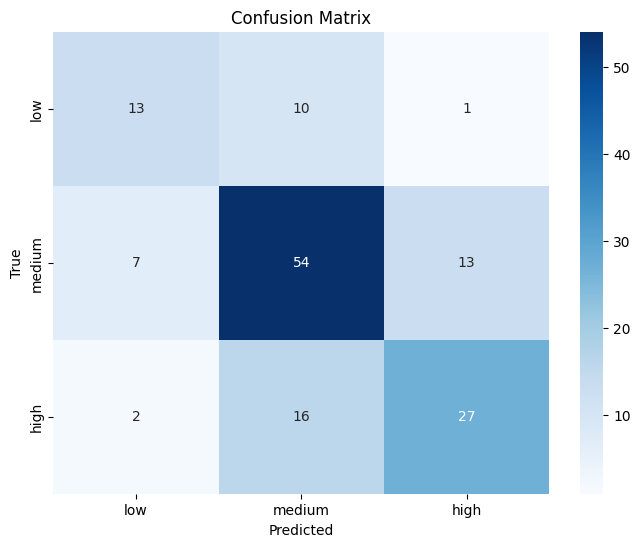

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_true = dataset['test']['label']

# Define your desired order
label_order = ['low', 'medium', 'high']
label_to_int = {label: i for i, label in enumerate(label_order)}

# Map labels to integers using the custom order
y_true_encoded = [label_to_int[label] for label in y_true]
y_pred_new_encoded = [label_to_int[label] for label in final_predictions]

# Print classification report
print(classification_report(y_true_encoded, y_pred_new_encoded, target_names=label_order))

# Generate confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_new_encoded)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_order, yticklabels=label_order)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()